In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

In [2]:
rng = np.random.RandomState(seed=1)
m1 = np.load('../matrices/2024_FULL-STACK.npy')
X = np.random.choice(m1[m1!=0.0].flatten(), (100000,1))

In [3]:
k_arr = np.arange(10) + 1
models = [
    GaussianMixture(n_components=k).fit(X)
    for k in k_arr
]

In [4]:
# Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(8000, 14000, 5000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot data histogram
    ax.hist(X, 1000, density=True, histtype='stepfilled', alpha=0.4, label ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    
    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()

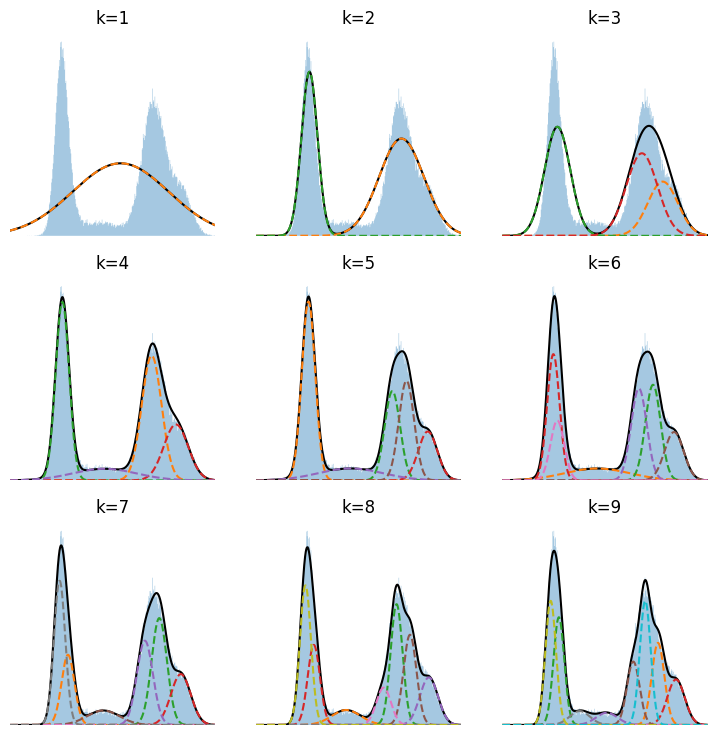

In [7]:
# Show all models for n_components 1 to 9
_, axes = plt.subplots(3,3,figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):
    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
    ax.set_xlim(9000, 13000)
    ax.axis('off')
plt.tight_layout
plt.show()

In [34]:
model = GaussianMixture(4).fit(X)

In [36]:
print(m1.shape)

(1085, 1085, 489)


In [38]:
test = model.predict(m1.reshape(-1,1))
test = test.reshape(m1.shape)

In [ ]:
plt.imshow(test[:,:,200])
plt.show()